# Knowledge Distillation on CIFAR-10


In [1]:
# Standard imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
# CIFAR-10 dataset
batch_size = 128
num_workers = 4 if torch.cuda.is_available() else 0

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

data_dir = './data'
train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

# Optionally split training into train/val
val_size = 5000
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

classes = train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') else train_dataset.classes
print('Classes:', classes)
print('Train batches:', len(train_loader), 'Val batches:', len(val_loader), 'Test batches:', len(test_loader))


100%|██████████| 170M/170M [00:03<00:00, 51.0MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train batches: 352 Val batches: 40 Test batches: 79


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
# Define teacher model (ResNet18) - modify final layer for CIFAR-10
def get_teacher(num_classes=10, pretrained=False):
    teacher = models.resnet18(pretrained=pretrained)
    # Adjust first conv to CIFAR size if desired (optional). We'll keep it and rely on CIFAR->224 resize if using pretrained.
    # Replace final fully connected layer:
    teacher.fc = nn.Linear(teacher.fc.in_features, num_classes)
    return teacher

teacher = get_teacher(num_classes=10, pretrained=False).to(device)
print(teacher)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# smaller student CNN
class StudentCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)  # 1x1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

student = StudentCNN(num_classes=10).to(device)
print(student)


StudentCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): AdaptiveAvgPool2d(output_size=1)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=128, out_features=10, bias=True)

In [5]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc='Train', leave=False)
    for xb, yb in pbar:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        _, predicted = preds.max(1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)
        pbar.set_postfix({'loss': running_loss/total, 'acc': correct/total})
    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            running_loss += loss.item() * xb.size(0)
            _, predicted = preds.max(1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    return running_loss/total, correct/total


In [6]:
# Train the teacher (or load pretrained state_dict if available)

teacher_path = './teacher_resnet18_cifar10.pth'
train_teacher = True  # set True to train teacher here

if train_teacher:
    epochs = 30
    optimizer = optim.SGD(teacher.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        tr_loss, tr_acc = train_epoch(teacher, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(teacher, val_loader, criterion, device)
        print(f"Epoch {epoch+1}: train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        scheduler.step()
    torch.save(teacher.state_dict(), teacher_path)
else:
    if os.path.exists(teacher_path):
        teacher.load_state_dict(torch.load(teacher_path, map_location=device))
        print('Loaded teacher from', teacher_path)
    else:
        print('No saved teacher found at', teacher_path, '\nYou can set train_teacher=True to train one.')

# Quick eval of teacher
criterion = nn.CrossEntropyLoss()
val_loss, val_acc = evaluate(teacher, val_loader, criterion, device)
print('Teacher val loss:', val_loss, 'val acc:', val_acc)


Epoch 1: train_loss=2.4128, train_acc=0.2521 | val_loss=1.7331, val_acc=0.3502


Epoch 2: train_loss=1.6272, train_acc=0.3965 | val_loss=1.5047, val_acc=0.4506


Epoch 3: train_loss=1.4372, train_acc=0.4776 | val_loss=1.4498, val_acc=0.4886


Epoch 4: train_loss=1.2772, train_acc=0.5401 | val_loss=1.2665, val_acc=0.5438


Epoch 5: train_loss=1.1656, train_acc=0.5839 | val_loss=1.1416, val_acc=0.5992


Epoch 6: train_loss=1.0672, train_acc=0.6215 | val_loss=1.0652, val_acc=0.6278


Epoch 7: train_loss=1.0104, train_acc=0.6444 | val_loss=1.3493, val_acc=0.5404


Epoch 8: train_loss=0.9637, train_acc=0.6610 | val_loss=1.0906, val_acc=0.6188


Epoch 9: train_loss=0.9193, train_acc=0.6783 | val_loss=1.0048, val_acc=0.6544


Epoch 10: train_loss=0.8895, train_acc=0.6928 | val_loss=0.9328, val_acc=0.6776


Epoch 11: train_loss=0.8684, train_acc=0.6972 | val_loss=0.9096, val_acc=0.6814


Epoch 12: train_loss=0.8422, train_acc=0.7088 | val_loss=0.9894, val_acc=0.6588


Epoch 13: train_loss=0.8207, train_acc=0.7156 | val_loss=1.0497, val_acc=0.6392


Epoch 14: train_loss=0.8122, train_acc=0.7197 | val_loss=0.9734, val_acc=0.6744


Epoch 15: train_loss=0.7945, train_acc=0.7276 | val_loss=0.8643, val_acc=0.7026


Epoch 16: train_loss=0.7808, train_acc=0.7314 | val_loss=0.8165, val_acc=0.7228


Epoch 17: train_loss=0.7753, train_acc=0.7306 | val_loss=0.8740, val_acc=0.7028


Epoch 18: train_loss=0.7613, train_acc=0.7401 | val_loss=0.8357, val_acc=0.7114


Epoch 19: train_loss=0.7617, train_acc=0.7402 | val_loss=0.8575, val_acc=0.7162


Epoch 20: train_loss=0.7538, train_acc=0.7417 | val_loss=0.8850, val_acc=0.6880


Epoch 21: train_loss=0.7449, train_acc=0.7438 | val_loss=0.9344, val_acc=0.6936


Epoch 22: train_loss=0.7373, train_acc=0.7487 | val_loss=0.7851, val_acc=0.7346


Epoch 23: train_loss=0.7217, train_acc=0.7545 | val_loss=0.7996, val_acc=0.7254


Epoch 24: train_loss=0.7222, train_acc=0.7519 | val_loss=0.9174, val_acc=0.6958


Epoch 25: train_loss=0.7222, train_acc=0.7516 | val_loss=0.9346, val_acc=0.6912


Epoch 26: train_loss=0.7203, train_acc=0.7536 | val_loss=0.7916, val_acc=0.7242


Epoch 27: train_loss=0.7090, train_acc=0.7573 | val_loss=0.7182, val_acc=0.7570


Epoch 28: train_loss=0.7028, train_acc=0.7599 | val_loss=0.8749, val_acc=0.7104


Epoch 29: train_loss=0.7009, train_acc=0.7603 | val_loss=0.7270, val_acc=0.7498


Epoch 30: train_loss=0.6963, train_acc=0.7620 | val_loss=0.8183, val_acc=0.7206
Teacher val loss: 0.8349171438217163 val acc: 0.7202


In [7]:
# Hinton et al., "Distilling the Knowledge in a Neural Network" (2015)
# https://arxiv.org/abs/1503.02531
# ------------------------------------------------------------
# loss = alpha * CE(student, hard_labels)
#       + (1 - alpha) * T^2 * KL(soft_student, soft_teacher)
# where:
#   soft_student = softmax(student / T)
#   soft_teacher = softmax(teacher / T)
# ============================================================

def kd_hinton_loss_fn(student_logits, teacher_logits, true_labels, temperature=4.0, alpha=0.5):
    # Cross-entropy with true labels
    ce_loss = F.cross_entropy(student_logits, true_labels)
    # Soft targets: KL divergence between softened probabilities
    p_student = F.log_softmax(student_logits / temperature, dim=1)
    p_teacher = F.softmax(teacher_logits / temperature, dim=1)
    kl_loss = F.kl_div(p_student, p_teacher, reduction='batchmean')
    loss = alpha * ce_loss + (1. - alpha) * (temperature ** 2) * kl_loss
    return loss, ce_loss, kl_loss


In [8]:
# Distillation training loop

def train_student_kd(student, teacher, train_loader, val_loader, epochs=20, lr=1e-3, temperature=4.0, alpha=0.5):
    teacher.eval()
    student.train()
    optimizer = optim.Adam(student.parameters(), lr=lr)
    best_val_acc = 0.0
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for xb, yb in pbar:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                teacher_logits = teacher(xb)
            student_logits = student(xb)
            loss, ce, kl = kd_hinton_loss_fn(student_logits, teacher_logits, yb, temperature=temperature, alpha=alpha)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
            _, predicted = student_logits.max(1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
            pbar.set_postfix({'loss': running_loss/total, 'acc': correct/total})
        train_loss = running_loss / total
        train_acc = correct / total
        val_loss, val_acc = evaluate(student, val_loader, nn.CrossEntropyLoss(), device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        # Save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student.state_dict(), 'student_kd_best.pth')
    print('Best val acc:', best_val_acc)
    return history


In [9]:
# Example hook setup:
teacher_features, student_features = {}, {}

def get_activation(name, storage):
    def hook(model, input, output):
        storage[name] = output
    return hook

# Register on a specific layer
teacher.layer4.register_forward_hook(get_activation('t_feat', teacher_features))
student.features[-2].register_forward_hook(get_activation('s_feat', student_features))


Epoch 1: train_loss=1.8079, train_acc=0.4163 | val_loss=1.3736, val_acc=0.5062


Epoch 2: train_loss=1.6623, train_acc=0.4624 | val_loss=1.3850, val_acc=0.5128


Epoch 3: train_loss=1.3530, train_acc=0.5346 | val_loss=1.2948, val_acc=0.5332


Epoch 4: train_loss=1.2469, train_acc=0.5632 | val_loss=1.2868, val_acc=0.5432


Epoch 5: train_loss=1.1628, train_acc=0.5856 | val_loss=1.1296, val_acc=0.5914


Epoch 6: train_loss=1.0958, train_acc=0.6056 | val_loss=1.0744, val_acc=0.6174


Epoch 7: train_loss=1.0483, train_acc=0.6223 | val_loss=1.0547, val_acc=0.6176


Epoch 8: train_loss=0.9936, train_acc=0.6342 | val_loss=1.0135, val_acc=0.6406


Epoch 9: train_loss=0.9508, train_acc=0.6475 | val_loss=0.9814, val_acc=0.6506


Epoch 10: train_loss=0.9176, train_acc=0.6627 | val_loss=0.9696, val_acc=0.6580


Epoch 11: train_loss=0.8767, train_acc=0.6737 | val_loss=0.9561, val_acc=0.6604


Epoch 12: train_loss=0.8419, train_acc=0.6823 | val_loss=0.8964, val_acc=0.6910


Epoch 13: train_loss=0.8167, train_acc=0.6946 | val_loss=0.9148, val_acc=0.6734


Epoch 14: train_loss=0.7909, train_acc=0.7021 | val_loss=0.8590, val_acc=0.7012


Epoch 15: train_loss=0.7708, train_acc=0.7106 | val_loss=0.8363, val_acc=0.7076


Epoch 16: train_loss=0.7509, train_acc=0.7164 | val_loss=0.8397, val_acc=0.6998


Epoch 17: train_loss=0.7336, train_acc=0.7233 | val_loss=0.8063, val_acc=0.7158


Epoch 18: train_loss=0.7188, train_acc=0.7299 | val_loss=0.8172, val_acc=0.7176


Epoch 19: train_loss=0.7051, train_acc=0.7346 | val_loss=0.7729, val_acc=0.7338


Epoch 20: train_loss=0.6905, train_acc=0.7414 | val_loss=0.8178, val_acc=0.7152
Best val acc: 0.7338


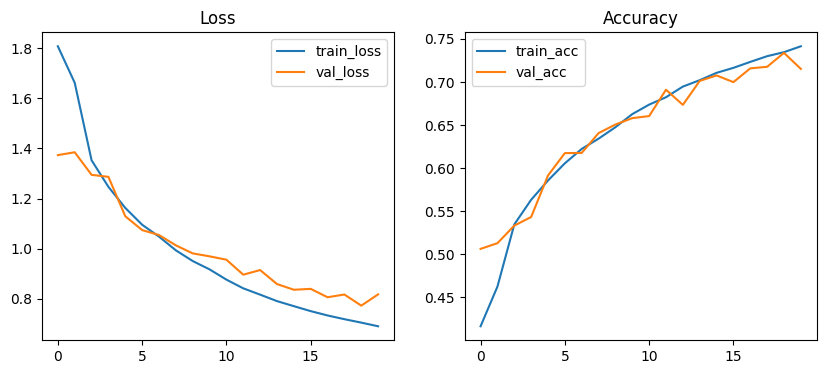

In [10]:
# Run distillation (set run_kd=True to perform training)
run_kd = True
if run_kd:
    # Optionally load a teacher checkpoint if not already loaded
    history = train_student_kd(student, teacher, train_loader, val_loader, epochs=20, lr=1e-3, temperature=4.0, alpha=0.5)
    # Plot training curves
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.legend()
    plt.title('Accuracy')
else:
    print('Set run_kd=True to train the student with knowledge distillation.')


Loaded student from student_kd_best.pth
Student test loss: 0.7665823686599731 test acc: 0.7338


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


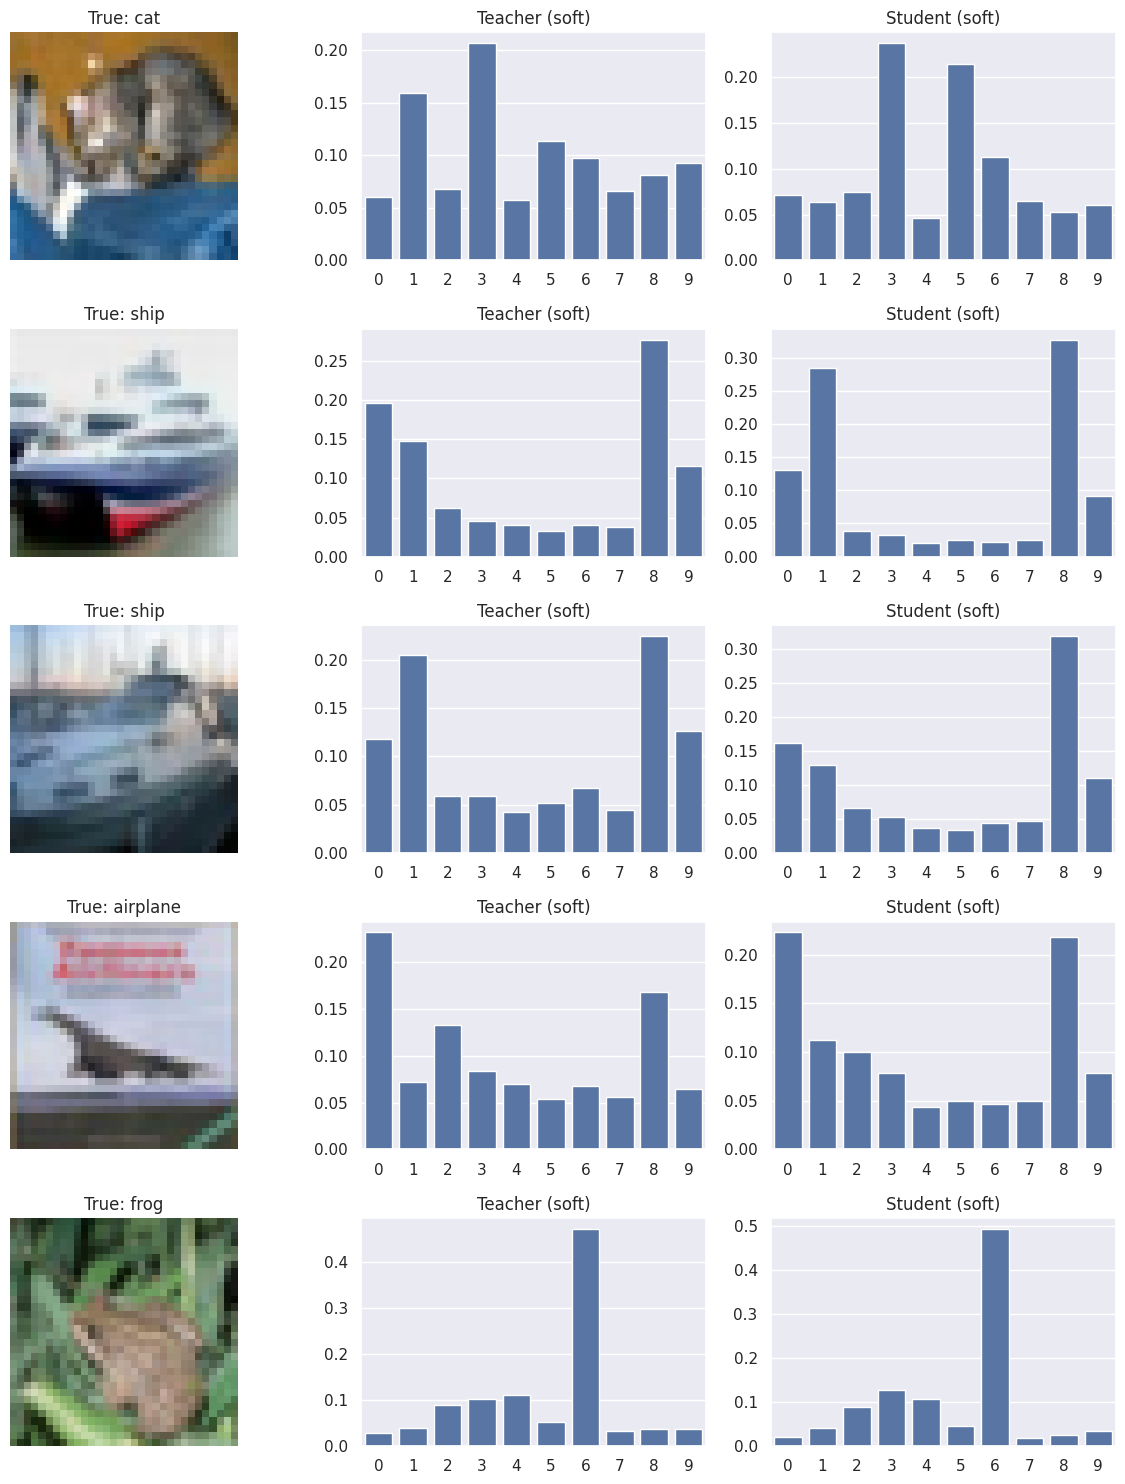

In [11]:
# Evaluate student (load best checkpoint if present)
student_path = 'student_kd_best.pth'
if os.path.exists(student_path):
    student.load_state_dict(torch.load(student_path, map_location=device))
    print('Loaded student from', student_path)
else:
    print('No student checkpoint found at', student_path)

criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(student, test_loader, criterion, device)
print('Student test loss:', test_loss, 'test acc:', test_acc)

# Visualize some predictions and teacher vs student soft logits for a few samples
import seaborn as sns
sns.set()

def visualize_logits(student, teacher, loader, n=5, temperature=4.0):
    student.eval(); teacher.eval()
    images = []
    student_probs = []
    teacher_probs = []
    labels = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            t_logits = teacher(xb)
            s_logits = student(xb)
            t_ps = F.softmax(t_logits / temperature, dim=1).cpu().numpy()
            s_ps = F.softmax(s_logits / temperature, dim=1).cpu().numpy()
            for i in range(min(n, xb.size(0))):
                images.append(xb[i].cpu())
                teacher_probs.append(t_ps[i])
                student_probs.append(s_ps[i])
                labels.append(yb[i].cpu().item())
            break
    # Plot images + barplots
    plt.figure(figsize=(12, 3*n))
    for i in range(n):
        ax = plt.subplot(n, 3, i*3 + 1)
        img = images[i]
        # unnormalize
        img = img * torch.tensor((0.247,0.243,0.261)).view(3,1,1) + torch.tensor((0.4914,0.4822,0.4465)).view(3,1,1)
        npimg = np.clip(img.permute(1,2,0).numpy(), 0, 1)
        ax.imshow(npimg)
        ax.set_title(f'True: {classes[labels[i]]}')
        ax.axis('off')

        ax2 = plt.subplot(n, 3, i*3 + 2)
        sns.barplot(x=list(range(len(teacher_probs[i]))), y=teacher_probs[i])
        ax2.set_title('Teacher (soft)')

        ax3 = plt.subplot(n, 3, i*3 + 3)
        sns.barplot(x=list(range(len(student_probs[i]))), y=student_probs[i])
        ax3.set_title('Student (soft)')
    plt.tight_layout()

# Visualize first batch from test loader
visualize_logits(student, teacher, test_loader, n=5, temperature=4.0)


# Задание на семинар

Реализовать 3 из лоссов ниже и попробовать дистиллировать предобученную модель (можно использовать свои вариации teacher и student моделей, вместо предложенных в семинаре). Нужно привести таблицу сравнения качества 2 выбранных лоссов и классического Hinton лосса.

In [12]:
# FitNets (Romero et al., "FitNets: Hints for Thin Deep Nets", 2015)
# https://arxiv.org/abs/1412.6550
# ------------------------------------------------------------
# loss = alpha * KD_loss
#       + beta * MSE(student_feature, teacher_feature)
# ============================================================

def fitnet_loss(student_logits, teacher_logits, student_feat, teacher_feat,
                targets, T=4.0, alpha=0.5, beta=50.0):
    ce_loss = F.cross_entropy(student_logits, targets)
    p_student = F.log_softmax(student_logits / T, dim=1)
    p_teacher = F.softmax(teacher_logits / T, dim=1)
    kl_loss = F.kl_div(p_student, p_teacher, reduction='batchmean')
    kd_loss = alpha * ce_loss + (1. - alpha) * (T ** 2) * kl_loss

    if student_feat.shape != teacher_feat.shape:
        if len(teacher_feat.shape) == 4:  # [B, C, H, W]
            teacher_feat = F.adaptive_avg_pool2d(teacher_feat, student_feat.shape[2:])
        elif len(teacher_feat.shape) == 2:  # [B, C]
            if len(student_feat.shape) == 4:
                teacher_feat = teacher_feat.view(teacher_feat.size(0), -1)
                student_feat = student_feat.view(student_feat.size(0), -1)

    feat_loss = F.mse_loss(student_feat, teacher_feat)

    total_loss = kd_loss + beta * feat_loss
    return total_loss, kd_loss, feat_loss

In [13]:
# Attention Transfer (Zagoruyko & Komodakis, 2017)
# https://arxiv.org/abs/1612.03928
# ------------------------------------------------------------
# Symbols:
#   F_t : teacher feature map  [B, C, H, W]
#   F_s : student feature map  [B, C, H, W]
#   mean_c : mean in channel dim
#
# ------------------------------------------------------------
# Full formula:
#     L_AT = || Normalize( mean_c(F_s^2) ) - Normalize( mean_c(F_t^2) ) ||_2^2
# ============================================================

def at_loss(student_feat, teacher_feat):
    # Ensure both are 4D tensors [B, C, H, W]
    if len(student_feat.shape) == 2:
        return torch.tensor(0.0, device=student_feat.device, requires_grad=True)

    if student_feat.shape[2:] != teacher_feat.shape[2:]:
        teacher_feat = F.adaptive_avg_pool2d(teacher_feat, student_feat.shape[2:])

    student_att = torch.mean(student_feat ** 2, dim=1)  # [B, H, W]
    teacher_att = torch.mean(teacher_feat ** 2, dim=1)  # [B, H, W]

    def normalize_attention(att):
        # att: [B, H, W]
        att_flat = att.view(att.size(0), -1)  # [B, H*W]
        att_norm = F.normalize(att_flat, p=2, dim=1)
        return att_norm.view_as(att)  # [B, H, W]

    student_att_norm = normalize_attention(student_att)
    teacher_att_norm = normalize_attention(teacher_att)

    loss = F.mse_loss(student_att_norm, teacher_att_norm)
    return loss

In [14]:
# Relational Knowledge Distillation (Park et al., 2019)
# https://arxiv.org/abs/1904.05068
# ------------------------------------------------------------
# loss = distance_loss + angle_loss
# where:
#   distance_loss = SmoothL1(pairwise_distance(student), pairwise_distance(teacher))
#   angle_loss    = SmoothL1(pairwise_angle(student), pairwise_angle(teacher))
# ============================================================

def rkd_loss(student_feat, teacher_feat):
    ...

In [15]:
# Contrastive Representation Distillation (Tian et al., 2020)
# https://arxiv.org/abs/1910.10699
# ------------------------------------------------------------
# Symbols:
#   s_i  -> feature vector from student for sample i
#   t_i  -> corresponding feature vector from teacher for sample i
#   t_j  -> teacher features of *other* samples (negatives)
#   τ (tau) -> temperature scaling factor for softmax sharpness
#
# Formula:
#   loss = -log( exp(sim(s_i, t_i)/τ) / sum_j exp(sim(s_i, t_j)/τ) )
#
# Where:
#   sim(a, b) = cosine_similarity(a, b)
# ============================================================

def crd_loss(student_feat, teacher_feat, temperature=0.07):
    ...

In [27]:
# Decoupled Knowledge Distillation (Zhao et al., CVPR 2022)
# https://arxiv.org/abs/2203.08679
# ------------------------------------------------------------
# Symbols:
#   p_t = teacher's softmax probabilities (teacher predictions)
#   p_s = student's softmax probabilities (student predictions)
#   y_true = ground truth class index
#   p_t_pos = teacher's predicted probability for the correct class
#   p_t_neg = sum of teacher probabilities for all *other* classes
#   log_s_pos = log of student's predicted prob for correct class
#   log_s_neg = log of student's total prob for all *other* classes
#
# Formula:
#   loss_target     = - (T^2) * mean(p_t_pos * log(p_s_pos))
#   loss_non_target = - (T^2) * mean(p_t_neg * log(p_s_neg))
#   total_loss = α * loss_target + β * loss_non_target
#
# Notes:
#   - T = temperature (same concept as in classic KD)
#   - α, β = balance weights between the two parts
# ============================================================

def dkd_loss(student_logits, teacher_logits, targets, alpha=1.0, beta=2.0, T=4.0, use_ce=True, ce_weight=1.0):
    p_t = F.softmax(teacher_logits / T, dim=1)  # [B, C]
    p_s = F.softmax(student_logits / T, dim=1)  # [B, C]
    log_p_s = F.log_softmax(student_logits / T, dim=1)  # [B, C]

    p_t_pos = p_t.gather(1, targets.unsqueeze(1)).squeeze(1)  # [B]
    p_s_pos = p_s.gather(1, targets.unsqueeze(1)).squeeze(1)  # [B]
    log_p_s_pos = log_p_s.gather(1, targets.unsqueeze(1)).squeeze(1)  # [B]

    p_t_neg = 1.0 - p_t_pos
    p_s_neg = 1.0 - p_s_pos
    log_p_s_neg = torch.log(p_s_neg + 1e-8)
    loss_target = - (T ** 2) * (p_t_pos * log_p_s_pos).mean()
    loss_non_target = - (T ** 2) * (p_t_neg * log_p_s_neg).mean()

    total_loss = alpha * loss_target + beta * loss_non_target
    if use_ce:
        ce_loss = F.cross_entropy(student_logits, targets)
        total_loss = total_loss + ce_weight * ce_loss
        return total_loss, loss_target, loss_non_target, ce_loss

    return total_loss, loss_target, loss_non_target


In [18]:
class StudentCNNWithFeatures(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, return_features=False):
        feat = self.features(x)
        if return_features:
            feat_intermediate = self.features[:-1](x)
            logits = self.classifier(feat)
            return logits, feat_intermediate
        logits = self.classifier(feat)
        return logits


In [19]:
def train_student_fitnet(student, teacher, train_loader, val_loader, epochs=20, lr=1e-3, T=4.0, alpha=0.5, beta=50.0):
    teacher.eval()
    student.train()
    optimizer = optim.Adam(student.parameters(), lr=lr)
    best_val_acc = 0.0
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

    teacher_features = {}
    student_features = {}

    def get_teacher_hook(name):
        def hook(module, input, output):
            teacher_features[name] = output
        return hook

    def get_student_hook(name):
        def hook(module, input, output):
            student_features[name] = output
        return hook

    teacher.layer2.register_forward_hook(get_teacher_hook('feat'))
    student.features[4].register_forward_hook(get_student_hook('feat'))

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for xb, yb in pbar:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(xb)
                teacher_feat = teacher_features['feat']

            student_logits, student_feat = student(xb, return_features=True)

            if teacher_feat.shape[2:] != student_feat.shape[2:]:
                teacher_feat = F.adaptive_avg_pool2d(teacher_feat, student_feat.shape[2:])

            loss, kd, feat = fitnet_loss(student_logits, teacher_logits, student_feat, teacher_feat,
                                        yb, T=T, alpha=alpha, beta=beta)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            _, predicted = student_logits.max(1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
            pbar.set_postfix({'loss': running_loss/total, 'acc': correct/total})

        train_loss = running_loss / total
        train_acc = correct / total
        val_loss, val_acc = evaluate(student, val_loader, nn.CrossEntropyLoss(), device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student.state_dict(), 'student_fitnet_best.pth')
    print('Best val acc:', best_val_acc)
    return history


In [20]:
def train_student_at(student, teacher, train_loader, val_loader, epochs=20, lr=1e-3, T=4.0, alpha=0.5, beta=1000.0):
    teacher.eval()
    student.train()
    optimizer = optim.Adam(student.parameters(), lr=lr)
    best_val_acc = 0.0
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

    teacher_features = {}
    student_features = {}

    def get_teacher_hook(name):
        def hook(module, input, output):
            teacher_features[name] = output
        return hook

    def get_student_hook(name):
        def hook(module, input, output):
            student_features[name] = output
        return hook

    teacher.layer2.register_forward_hook(get_teacher_hook('feat'))
    student.features[4].register_forward_hook(get_student_hook('feat'))

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for xb, yb in pbar:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(xb)
                teacher_feat = teacher_features['feat']

            student_logits, student_feat = student(xb, return_features=True)

            at_loss_val = at_loss(student_feat, teacher_feat)

            ce_loss = F.cross_entropy(student_logits, yb)
            p_student = F.log_softmax(student_logits / T, dim=1)
            p_teacher = F.softmax(teacher_logits / T, dim=1)
            kl_loss = F.kl_div(p_student, p_teacher, reduction='batchmean')
            kd_loss = alpha * ce_loss + (1. - alpha) * (T ** 2) * kl_loss

            loss = kd_loss + beta * at_loss_val
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            _, predicted = student_logits.max(1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
            pbar.set_postfix({'loss': running_loss/total, 'acc': correct/total})

        train_loss = running_loss / total
        train_acc = correct / total
        val_loss, val_acc = evaluate(student, val_loader, nn.CrossEntropyLoss(), device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student.state_dict(), 'student_at_best.pth')
    print('Best val acc:', best_val_acc)
    return history


In [28]:
def train_student_dkd(student, teacher, train_loader, val_loader, epochs=20, lr=1e-3, T=4.0, alpha=1.0, beta=2.0, ce_weight=1.0):
    teacher.eval()
    student.train()
    optimizer = optim.Adam(student.parameters(), lr=lr)
    best_val_acc = 0.0
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for xb, yb in pbar:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(xb)

            student_logits = student(xb)
            result = dkd_loss(student_logits, teacher_logits, yb,
                            alpha=alpha, beta=beta, T=T, use_ce=True, ce_weight=ce_weight)
            if len(result) == 4:
                loss, loss_target, loss_non_target, ce_loss = result
            else:
                loss, loss_target, loss_non_target = result

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            _, predicted = student_logits.max(1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
            pbar.set_postfix({'loss': running_loss/total, 'acc': correct/total})

        train_loss = running_loss / total
        train_acc = correct / total
        val_loss, val_acc = evaluate(student, val_loader, nn.CrossEntropyLoss(), device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student.state_dict(), 'student_dkd_best.pth')
    print('Best val acc:', best_val_acc)
    return history



In [22]:
teacher_path = './teacher_resnet18_cifar10.pth'
if os.path.exists(teacher_path):
    teacher.load_state_dict(torch.load(teacher_path, map_location=device))
    print('Loaded teacher from', teacher_path)
teacher.eval()

teacher_test_loss, teacher_test_acc = evaluate(teacher, test_loader, nn.CrossEntropyLoss(), device)
print(f'Teacher test accuracy: {teacher_test_acc:.4f}')

results = {}


Loaded teacher from ./teacher_resnet18_cifar10.pth


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Teacher test accuracy: 0.7296


In [23]:
print("=" * 60)
print("Training with Hinton KD Loss")
print("=" * 60)
student_hinton = StudentCNN(num_classes=10).to(device)
history_hinton = train_student_kd(student_hinton, teacher, train_loader, val_loader,
                                   epochs=20, lr=1e-3, temperature=4.0, alpha=0.5)
test_loss_hinton, test_acc_hinton = evaluate(student_hinton, test_loader, nn.CrossEntropyLoss(), device)
results['Hinton KD'] = {
    'val_acc': max(history_hinton['val_acc']),
    'test_acc': test_acc_hinton,
    'test_loss': test_loss_hinton
}
print(f'Hinton KD - Test Accuracy: {test_acc_hinton:.4f}')


Training with Hinton KD Loss


Epoch 1: train_loss=1.7986, train_acc=0.4219 | val_loss=1.7455, val_acc=0.4126


Epoch 2: train_loss=1.7092, train_acc=0.4501 | val_loss=1.3163, val_acc=0.5176


Epoch 3: train_loss=1.3339, train_acc=0.5348 | val_loss=1.2382, val_acc=0.5464


Epoch 4: train_loss=1.2250, train_acc=0.5640 | val_loss=1.1916, val_acc=0.5750


Epoch 5: train_loss=1.1488, train_acc=0.5915 | val_loss=1.1363, val_acc=0.5896


Epoch 6: train_loss=1.0872, train_acc=0.6068 | val_loss=1.0976, val_acc=0.6062


Epoch 7: train_loss=1.0375, train_acc=0.6214 | val_loss=1.0713, val_acc=0.6230


Epoch 8: train_loss=0.9925, train_acc=0.6364 | val_loss=1.0314, val_acc=0.6354


Epoch 9: train_loss=0.9584, train_acc=0.6462 | val_loss=0.9784, val_acc=0.6532


Epoch 10: train_loss=0.9185, train_acc=0.6606 | val_loss=0.9953, val_acc=0.6448


Epoch 11: train_loss=0.8900, train_acc=0.6710 | val_loss=0.9459, val_acc=0.6762


Epoch 12: train_loss=0.8571, train_acc=0.6814 | val_loss=0.9211, val_acc=0.6768


Epoch 13: train_loss=0.8252, train_acc=0.6933 | val_loss=0.8667, val_acc=0.6932


Epoch 14: train_loss=0.8086, train_acc=0.6988 | val_loss=0.8797, val_acc=0.6876


Epoch 15: train_loss=0.7848, train_acc=0.7078 | val_loss=0.8351, val_acc=0.7150


Epoch 16: train_loss=0.7571, train_acc=0.7145 | val_loss=0.8739, val_acc=0.6948


Epoch 17: train_loss=0.7455, train_acc=0.7210 | val_loss=0.7978, val_acc=0.7274


Epoch 18: train_loss=0.7265, train_acc=0.7281 | val_loss=0.7867, val_acc=0.7284


Epoch 19: train_loss=0.7128, train_acc=0.7329 | val_loss=0.7945, val_acc=0.7246


Epoch 20: train_loss=0.6950, train_acc=0.7378 | val_loss=0.7837, val_acc=0.7302
Best val acc: 0.7302
Hinton KD - Test Accuracy: 0.7305


In [24]:
print("=" * 60)
print("Training with FitNets Loss")
print("=" * 60)
student_fitnet = StudentCNNWithFeatures(num_classes=10).to(device)
history_fitnet = train_student_fitnet(student_fitnet, teacher, train_loader, val_loader,
                                      epochs=20, lr=1e-3, T=4.0, alpha=0.5, beta=50.0)
test_loss_fitnet, test_acc_fitnet = evaluate(student_fitnet, test_loader, nn.CrossEntropyLoss(), device)
results['FitNets'] = {
    'val_acc': max(history_fitnet['val_acc']),
    'test_acc': test_acc_fitnet,
    'test_loss': test_loss_fitnet
}
print(f'FitNets - Test Accuracy: {test_acc_fitnet:.4f}')


Training with FitNets Loss


Epoch 1: train_loss=7.8805, train_acc=0.2151 | val_loss=1.9227, val_acc=0.2792


Epoch 2: train_loss=5.0987, train_acc=0.3101 | val_loss=1.6535, val_acc=0.3486


Epoch 3: train_loss=4.4891, train_acc=0.3896 | val_loss=1.5400, val_acc=0.4146


Epoch 4: train_loss=4.1545, train_acc=0.4554 | val_loss=1.4481, val_acc=0.4376


Epoch 5: train_loss=3.9436, train_acc=0.4950 | val_loss=1.3012, val_acc=0.5242


Epoch 6: train_loss=3.8032, train_acc=0.5227 | val_loss=1.2692, val_acc=0.5440


Epoch 7: train_loss=3.6919, train_acc=0.5457 | val_loss=1.2408, val_acc=0.5602


Epoch 8: train_loss=3.6032, train_acc=0.5596 | val_loss=1.2230, val_acc=0.5614


Epoch 9: train_loss=3.5324, train_acc=0.5753 | val_loss=1.1528, val_acc=0.5862


Epoch 10: train_loss=3.4781, train_acc=0.5866 | val_loss=1.1155, val_acc=0.6042


Epoch 11: train_loss=3.4352, train_acc=0.5955 | val_loss=1.1475, val_acc=0.5856


Epoch 12: train_loss=3.3841, train_acc=0.6044 | val_loss=1.0991, val_acc=0.6054


Epoch 13: train_loss=3.3482, train_acc=0.6108 | val_loss=1.0678, val_acc=0.6128


Epoch 14: train_loss=3.3168, train_acc=0.6206 | val_loss=1.0998, val_acc=0.6072


Epoch 15: train_loss=3.2973, train_acc=0.6233 | val_loss=1.0861, val_acc=0.6172


Epoch 16: train_loss=3.2570, train_acc=0.6358 | val_loss=0.9873, val_acc=0.6508


Epoch 17: train_loss=3.2444, train_acc=0.6364 | val_loss=1.0115, val_acc=0.6432


Epoch 18: train_loss=3.2197, train_acc=0.6434 | val_loss=0.9904, val_acc=0.6478


Epoch 19: train_loss=3.1992, train_acc=0.6483 | val_loss=1.0201, val_acc=0.6372


Epoch 20: train_loss=3.1778, train_acc=0.6525 | val_loss=1.0578, val_acc=0.6248
Best val acc: 0.6508
FitNets - Test Accuracy: 0.6315


In [25]:
print("=" * 60)
print("Training with Attention Transfer Loss")
print("=" * 60)
student_at = StudentCNNWithFeatures(num_classes=10).to(device)
history_at = train_student_at(student_at, teacher, train_loader, val_loader,
                              epochs=20, lr=1e-3, T=4.0, alpha=0.5, beta=1000.0)
test_loss_at, test_acc_at = evaluate(student_at, test_loader, nn.CrossEntropyLoss(), device)
results['Attention Transfer'] = {
    'val_acc': max(history_at['val_acc']),
    'test_acc': test_acc_at,
    'test_loss': test_loss_at
}
print(f'Attention Transfer - Test Accuracy: {test_acc_at:.4f}')


Training with Attention Transfer Loss


Epoch 1: train_loss=4.9044, train_acc=0.3322 | val_loss=1.5351, val_acc=0.4192


Epoch 2: train_loss=4.0331, train_acc=0.4664 | val_loss=1.4039, val_acc=0.4800


Epoch 3: train_loss=3.6841, train_acc=0.5277 | val_loss=1.2293, val_acc=0.5582


Epoch 4: train_loss=3.4987, train_acc=0.5632 | val_loss=1.2062, val_acc=0.5602


Epoch 5: train_loss=3.3658, train_acc=0.5921 | val_loss=1.1250, val_acc=0.5986


Epoch 6: train_loss=3.2635, train_acc=0.6123 | val_loss=1.0595, val_acc=0.6174


Epoch 7: train_loss=3.1632, train_acc=0.6335 | val_loss=1.0148, val_acc=0.6348


Epoch 8: train_loss=3.0780, train_acc=0.6524 | val_loss=0.9764, val_acc=0.6536


Epoch 9: train_loss=3.0248, train_acc=0.6634 | val_loss=0.9358, val_acc=0.6740


Epoch 10: train_loss=2.9715, train_acc=0.6740 | val_loss=0.9616, val_acc=0.6556


Epoch 11: train_loss=2.9202, train_acc=0.6869 | val_loss=0.8664, val_acc=0.6952


Epoch 12: train_loss=2.8791, train_acc=0.6936 | val_loss=0.9378, val_acc=0.6676


Epoch 13: train_loss=2.8549, train_acc=0.7022 | val_loss=0.8414, val_acc=0.7102


Epoch 14: train_loss=2.8351, train_acc=0.7083 | val_loss=0.8687, val_acc=0.6988


Epoch 15: train_loss=2.8010, train_acc=0.7151 | val_loss=0.8190, val_acc=0.7222


Epoch 16: train_loss=2.7858, train_acc=0.7194 | val_loss=0.8494, val_acc=0.7022


Epoch 17: train_loss=2.7601, train_acc=0.7214 | val_loss=0.7957, val_acc=0.7240


Epoch 18: train_loss=2.7445, train_acc=0.7282 | val_loss=0.7970, val_acc=0.7276


Epoch 19: train_loss=2.7212, train_acc=0.7337 | val_loss=0.8258, val_acc=0.7118


Epoch 20: train_loss=2.7167, train_acc=0.7358 | val_loss=0.7828, val_acc=0.7296
Best val acc: 0.7296
Attention Transfer - Test Accuracy: 0.7278


In [29]:
print("=" * 60)
print("Training with Decoupled Knowledge Distillation")
print("=" * 60)
student_dkd = StudentCNN(num_classes=10).to(device)
history_dkd = train_student_dkd(student_dkd, teacher, train_loader, val_loader,
                                epochs=20, lr=1e-3, T=4.0, alpha=1.0, beta=2.0, ce_weight=1.0)
test_loss_dkd, test_acc_dkd = evaluate(student_dkd, test_loader, nn.CrossEntropyLoss(), device)
results['DKD'] = {
    'val_acc': max(history_dkd['val_acc']),
    'test_acc': test_acc_dkd,
    'test_loss': test_loss_dkd
}
print(f'DKD - Test Accuracy: {test_acc_dkd:.4f}')


Training with Decoupled Knowledge Distillation


Epoch 1: train_loss=13.6737, train_acc=0.4141 | val_loss=1.4150, val_acc=0.4908


Epoch 2: train_loss=13.3943, train_acc=0.4824 | val_loss=1.3032, val_acc=0.5296


Epoch 3: train_loss=13.1494, train_acc=0.5572 | val_loss=1.2052, val_acc=0.5784


Epoch 4: train_loss=13.0540, train_acc=0.5885 | val_loss=1.1862, val_acc=0.5898


Epoch 5: train_loss=12.9918, train_acc=0.6062 | val_loss=1.1166, val_acc=0.6140


Epoch 6: train_loss=12.9473, train_acc=0.6277 | val_loss=1.1096, val_acc=0.6230


Epoch 7: train_loss=12.8997, train_acc=0.6396 | val_loss=1.0773, val_acc=0.6300


Epoch 8: train_loss=12.8523, train_acc=0.6583 | val_loss=1.0327, val_acc=0.6666


Epoch 9: train_loss=12.8317, train_acc=0.6695 | val_loss=1.0215, val_acc=0.6718


Epoch 10: train_loss=12.8016, train_acc=0.6831 | val_loss=0.9886, val_acc=0.6826


Epoch 11: train_loss=12.7754, train_acc=0.6907 | val_loss=0.9824, val_acc=0.6924


Epoch 12: train_loss=12.7401, train_acc=0.7018 | val_loss=0.9538, val_acc=0.7012


Epoch 13: train_loss=12.7225, train_acc=0.7099 | val_loss=0.9545, val_acc=0.7158


Epoch 14: train_loss=12.7061, train_acc=0.7182 | val_loss=0.9551, val_acc=0.7052


Epoch 15: train_loss=12.6846, train_acc=0.7258 | val_loss=0.9104, val_acc=0.7220


Epoch 16: train_loss=12.6684, train_acc=0.7312 | val_loss=0.8898, val_acc=0.7350


Epoch 17: train_loss=12.6632, train_acc=0.7355 | val_loss=0.8881, val_acc=0.7304


Epoch 18: train_loss=12.6521, train_acc=0.7425 | val_loss=0.8599, val_acc=0.7374


Epoch 19: train_loss=12.6361, train_acc=0.7492 | val_loss=0.8718, val_acc=0.7446


Epoch 20: train_loss=12.6238, train_acc=0.7550 | val_loss=0.8572, val_acc=0.7424
Best val acc: 0.7446
DKD - Test Accuracy: 0.7446



СРАВНЕНИЕ КАЧЕСТВА
            Method  Validation Accuracy  Test Accuracy  Test Loss
         Hinton KD               0.7302         0.7305   0.769873
           FitNets               0.6508         0.6315   1.055161
Attention Transfer               0.7296         0.7278   0.770983
               DKD               0.7446         0.7446   0.801894


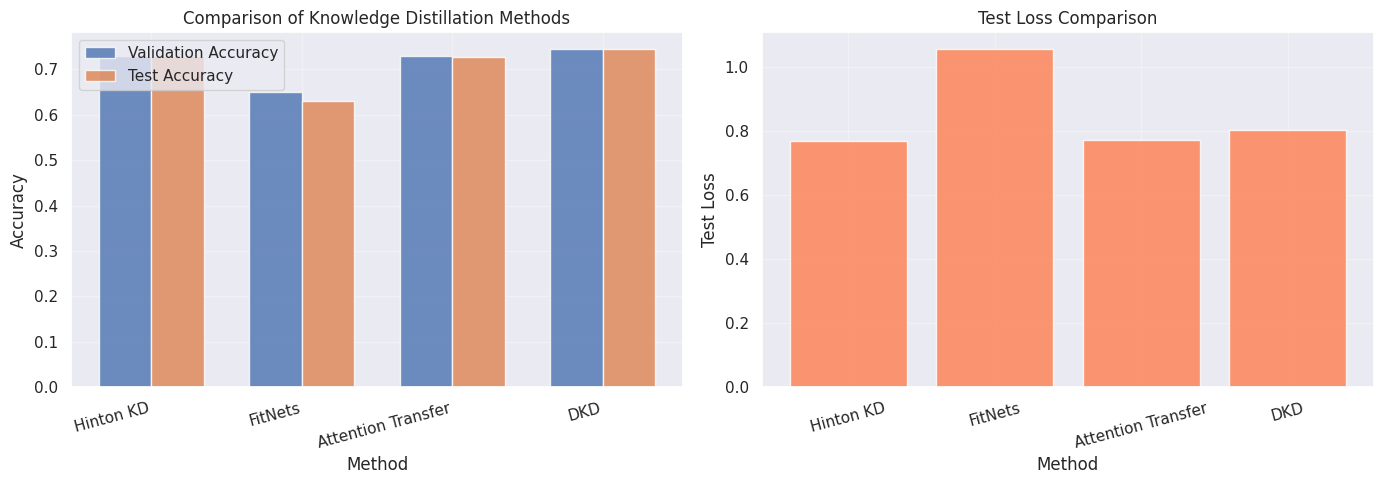

In [31]:
comparison_data = {
    'Method': ['Hinton KD', 'FitNets', 'Attention Transfer', 'DKD'],
    'Validation Accuracy': [
        results['Hinton KD']['val_acc'],
        results['FitNets']['val_acc'],
        results['Attention Transfer']['val_acc'],
        results['DKD']['val_acc']
    ],
    'Test Accuracy': [
        results['Hinton KD']['test_acc'],
        results['FitNets']['test_acc'],
        results['Attention Transfer']['test_acc'],
        results['DKD']['test_acc']
    ],
    'Test Loss': [
        results['Hinton KD']['test_loss'],
        results['FitNets']['test_loss'],
        results['Attention Transfer']['test_loss'],
        results['DKD']['test_loss']
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "=" * 80)
print("СРАВНЕНИЕ КАЧЕСТВА")
print("=" * 80)
print(df_comparison.to_string(index=False))
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods = df_comparison['Method']
val_accs = df_comparison['Validation Accuracy']
test_accs = df_comparison['Test Accuracy']

x = np.arange(len(methods))
width = 0.35

axes[0].bar(x - width/2, val_accs, width, label='Validation Accuracy', alpha=0.8)
axes[0].bar(x + width/2, test_accs, width, label='Test Accuracy', alpha=0.8)
axes[0].set_xlabel('Method')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Comparison of Knowledge Distillation Methods')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

test_losses = df_comparison['Test Loss']
axes[1].bar(methods, test_losses, alpha=0.8, color='coral')
axes[1].set_xlabel('Method')
axes[1].set_ylabel('Test Loss')
axes[1].set_title('Test Loss Comparison')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
